# Google landmark recognition challenge (on kaggle)
## Finetuning the Xception CNN with a generalized mean pool (and custom loss function)

### Google landmark recognition challenge

The kaggle competition was about the classification of about 15000 landmark categories from images, see
https://www.kaggle.com/c/landmark-recognition-challenge for details.

Main challenges:

- large number of categories
- imbalanced training set (only a few training images for some categories)
- very hard test set (only a small fraction of images actually depict landmarks)
- GAP (global average precision) metrics (i.e. confidence scores are very important)

### Full solution and validation result

My full solution consists of two stages, the first stage is given by this NN classifier, which proposes a single landmark and a confidence score per image. This resulted in a (public/private) GAP of 0.145/0.149 and would have corresponded to the 34th place. (On an easy dev set comparable to the training data without non-landmark images, this model has a GAP of about 0.96).

As a second step I used Google DELF features (https://arxiv.org/abs/1612.06321) to rescore every image by comparing it to (up to) 32 landmark images of the proposed category, the maximal number of matching features after geometric verification is used as a DELF-based score. The source code for the DELF prediction and analysis was developed based on the examples in the tensorflow repository.

The total confidence for the prediction is then computed by a weighted average of NN and DELF confidence, so that the NN and the DELF confidences contribute roughly half for images with typical DELF-based scores (wheras very high DELF scores dominate the average).

The full model lead to a GAP of (public/private) 0.211/0.192, which resulted in the 19th place (out of 483).

### Finetuning a pretrained Xception-CNN with a generalized mean pool

Here, we finetune a pretrained Xception deep convolutional neural network (input resolution: 299x299) using the keras library with tensorflow backend for the customizations described below. A classifier with 15000 outputs and a sigmoid activation is used as the final layer. The latter has the advantage that the model can more naturally reject non-landmark images.

The model was trained on the about 1,200,000 landmark images plus about 200,000 non-landmark images from various sources. I first trained the classifier of the `top_model`, and then included some additional layers of the network (see the comment in the code). 

#### Generalized average pool

A generalized average pooling layer has been shown to improve landmark recognition performance (https://arxiv.org/pdf/1711.02512.pdf). It is given by
\begin{equation}
f_k=\left(\frac{1}{N} \sum_i a_{ik}^p \right)^{\frac{1}{p}},
\end{equation}
where $a_{ik}$ denote the activations in the last block of the CNN in the channel $k$. The advantage seems to be that the network can better suppress non-relevant features. The exponent $p\approx2.2$ was learned during training. 

#### Reweighted loss function

I slightly changed the standard binary cross entropy loss function by sorting the top predictions on each batch and increased the binary crossentropy loss proportional to the rank. This way, wrong predictions with a high confidence are suppressed. This worked well for a toy model, but I could not afford the computational power to compare it to a reference network trained without this feature. Thus, it could well be that this modification has no effect or that it even slowes down learning, but clearly it didn't hurt the overall model performance.

#### batch_GAP

To better supervise training, I implemented a custom metric `batch_GAP`, which calculates the GAP on each batch.

#### 22 crops at prediction

At prediction, I used several (22 for the scores given above) crops of each image and calculated the image category and confidence by a simple voting procedure. This significantly improves performance (by about 10%), because of the large number of output categories and the fact that most of the test images do not depict any landmark, and it is clearly computationally cheaper than training additional models.

In [218]:
%load_ext autoreload
%autoreload 2

import glob
import warnings

import cv2
import numpy as np
import pandas as pd

import keras
import keras.backend as K

from keras import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from keras.layers import BatchNormalization, Activation, Conv2D
from keras.layers import GlobalAveragePooling2D, Lambda
from keras.optimizers import Adam, RMSprop

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

print('Keras version:', keras.__version__)

warnings.simplefilter('default')
warnings.simplefilter('ignore') # Tyler: Get rid of deprecation warnings
basic_version = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Keras version: 2.2.4


#### Set a few global parameters and directories

In [219]:
# train_path = './train-highres/'
# non_landmark_train_path = './distractors/*/'
# dev_path = './dev/'
# non_landmark_dev_path = './distractors-dev/'
# test_path = './test-highres/'

# n_cat = 14942

# batch_size = 48
# batch_size_predict = 128
# input_shape = (299,299)


data_path = '../data/'
train_path = '../data/images/train-subset/' # on macs, change backslash
dev_path = train_path

n_cat = 5 # classes examining

batch_size = 16
batch_size_predict = 16
input_shape = (299,299)

#### Data preparation

Most of the code lines deal with missing images and the fact that I had started with low resolution images and that the high resolution image collection had different missing images compared to the low resolution collection.

Basically, the following lines load the dataframes provided by kaggle, remove all missing images and add a field `filename` with a path to the downloaded jpg file.

There are 5 dataframes:
* train_info: train, landmark images
* nlm_df: train, non-landmark images
* dev_info: dev, landmark images
* nlm_dev_df: dev, non-landmark images
* test_info: test images

In [220]:
train_image_files = glob.glob(train_path+'*.jpg')
train_image_ids = [image_file.replace('.jpg', '').replace(train_path, '') for image_file in train_image_files]
train_info_full = pd.read_csv(data_path+'train-subset.csv', index_col='id')
train_info_full.head()
train_info = train_info_full.loc[train_image_ids]
train_info['filename'] = pd.Series(train_image_files, index=train_image_ids)

# Heidi: commented out b/c our subset should not be missing any images
# train_info_correct = pd.read_csv('train_info_correct.csv', index_col='id')
# train_info = train_info[train_info['landmark_id'].isin(train_info_correct['landmark_id'])]

In [221]:
if not basic_version:
    non_landmark_image_files=glob.glob(non_landmark_train_path + '*.jp*g')
    nlm_df=pd.DataFrame({'filename': non_landmark_image_files})
    nlm_df['landmark_id']=-1
    print(len(nlm_df))
    nlm_df.head()

In [222]:
n_cat_train=train_info['landmark_id'].nunique()
print(n_cat_train)
if n_cat_train != n_cat:
    warnings.warn('Warning: The training data is not compatible.')

5


In [223]:
# if not basic_version:
dev_image_files = glob.glob(dev_path + '*.jpg')
dev_image_ids = [image_file.replace(
    '.jpg', '').replace(dev_path, '') for image_file in dev_image_files]
dev_info = train_info_full.loc[dev_image_ids]
dev_info['filename'] = pd.Series(dev_image_files, index=dev_image_ids)
dev_info.head()

,url,landmark_id,filename
id,,,
beef63d6a6236b9d,http://lh4.ggpht.com/-ykFvxrAjAjY/S9XZnI-uQaI/...,9779,../data/images/train-subset/beef63d6a6236b9d.jpg
4c8fb1fc94f3cabf,http://lh3.ggpht.com/-IewXaHvMVQc/RZhs1KEWXZI/...,6051,../data/images/train-subset/4c8fb1fc94f3cabf.jpg
779e3ce783d13c85,http://lh6.ggpht.com/-j2-SZ9UqBrs/Tgx_kufPd4I/...,2061,../data/images/train-subset/779e3ce783d13c85.jpg
b71482512fb35ebc,http://lh5.ggpht.com/-8JDVt995ndQ/UEtFkI3t24I/...,9779,../data/images/train-subset/b71482512fb35ebc.jpg
bb4a1aed895f7f09,http://lh3.ggpht.com/-sbx72QueShg/SOJxoiXqOXI/...,6599,../data/images/train-subset/bb4a1aed895f7f09.jpg


In [224]:
if not basic_version:
    non_landmark_dev_image_files = glob.glob(non_landmark_dev_path+'*.jpg')
    nlm_dev_df = pd.DataFrame({'filename':non_landmark_dev_image_files})
    nlm_dev_df['landmark_id'] = -1
    print(len(nlm_dev_df))
    nlm_dev_df.head()

In [225]:
if not basic_version:
    test_info_full = pd.read_csv('test.csv', index_col='id')
    test_info_full.head()

    test_image_files = glob.glob(test_path + '*.jpg')
    test_image_ids = [image_file.replace(
        '.jpg', '').replace(test_path, '') for image_file in test_image_files]

    test_info = test_info_full.loc[test_image_ids]
    test_info['filename'] = pd.Series(test_image_files, index=test_image_ids)

    test_info.head()

Landmark_id of image ../data/images/train-subset/beef63d6a6236b9d.jpg : 9779
9779


(1024, 681, 3)

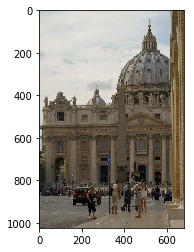

In [226]:
print("Landmark_id of image", train_image_files[0], ":", 
      train_info.loc[train_image_ids[0]]['landmark_id'])
print(train_info["landmark_id"].max())
testimg = cv2.cvtColor(cv2.imread(np.random.choice(train_image_files)), cv2.COLOR_BGR2RGB)
plt.imshow(testimg)
testimg.shape

In [227]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=True, n_values=n_cat)

train_info['label'] = label_encoder.fit_transform(train_info['landmark_id'].values)
train_info['one_hot'] = one_hot_encoder.fit_transform(
                    train_info['label'].values.reshape(-1, 1))

### Image i/o and image data augmentation

Standard keras image augmentation is used and in addition random crops (with slighter additional augmentation) are scaled to full resolution. Since the original images have a higher resolution than this model, the crops will contain additional information.

In [228]:
def load_images(info, input_shape = input_shape):
    input_shape = tuple(input_shape)
    imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))

    for i in range(len(info)):
        fname = info.iloc[i]['filename']
        try:
            img = cv2.cvtColor(
                  cv2.resize(cv2.imread(fname),input_shape),
                  cv2.COLOR_BGR2RGB)
        except:
            warnings.warn('Warning: could not read image: '+ fname +
                          '. Use black img instead.')
            img = np.zeros((input_shape[0], input_shape[1], 3))
        imgs[i,:,:,:] = img
    
    return imgs

In [229]:
def load_cropped_images(info, crop_p=0.2, crop='random'):
    new_res = np.array([int(input_shape[0]*(1+crop_p)), int(input_shape[1]*(1+crop_p))])
    if crop == 'random':
        cx0 = np.random.randint(new_res[0] - input_shape[0], size=len(info))
        cy0 = np.random.randint(new_res[1] - input_shape[1], size=len(info))
    else:
        if crop == 'central':
            cx0, cy0 = (new_res - input_shape) // 2                
        if crop == 'upper left':
            cx0, cy0 = 0, 0
        if crop == 'upper right':
            cx0, cy0 = new_res[1] - input_shape[1], 0
        if crop == 'lower left':
            cx0, cy0 = 0, new_res[0] - input_shape[0]
        if crop=='lower right':
            cx0, cy0 = new_res - input_shape        
        cx0 = np.repeat(np.expand_dims(cx0, 0), len(info))
        cy0 = np.repeat(np.expand_dims(cy0, 0), len(info))

    cx1 = cx0 + input_shape[0]
    cy1 = cy0 + input_shape[1]
    
    raw_imgs = load_images(info, input_shape=tuple(new_res))
    
    cropped_imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))
    for ind in range(len(info)):
        cropped_imgs[ind,:,:,:] = raw_imgs[ind,
                                           cy0[ind]:cy1[ind],
                                           cx0[ind]:cx1[ind], :]
    
    return cropped_imgs

Create the image data generator which is used for training

In [230]:
def get_image_gen(info_arg, 
                  shuffle=True, 
                  image_aug=True, 
                  eq_dist=False, 
                  n_ref_imgs=16, 
                  crop_prob=0.5, 
                  crop_p=0.5):
    if image_aug:
        datagen = ImageDataGenerator(
            rotation_range=4.,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.5,
            channel_shift_range=25,
            horizontal_flip=True,
            fill_mode='nearest')
        
        if crop_prob > 0:
            datagen_crop = ImageDataGenerator(
                rotation_range=4.,
                shear_range=0.2,
                zoom_range=0.1,
                channel_shift_range=20,
                horizontal_flip=True,
                fill_mode='nearest')
        
    count = len(info_arg)
    while True:
        if eq_dist:
            def sample(df):
                return df.sample(min(n_ref_imgs, len(df)))
            info = info_arg.groupby('landmark_id', group_keys=False).apply(sample)
        else:
            info = info_arg
        print('Generate', len(info), 'for the next round.')
        
        #shuffle data
        if shuffle and count >= len(info):
            info = info.sample(frac=1)
            count = 0
            
        # load images
        for ind in range(0,len(info), batch_size):
            count += batch_size

            y = info['landmark_id'].values[ind:(ind+batch_size)]
            
            if np.random.rand() < crop_prob:
                imgs = load_cropped_images(info.iloc[ind:(ind+batch_size)], 
                                           crop_p=crop_p*np.random.rand() + 0.01, 
                                           crop='random')
                if image_aug:
                    cflow = datagen_crop.flow(imgs, 
                                              y, 
                                              batch_size=imgs.shape[0], 
                                              shuffle=False)
                    imgs, y = next(cflow)                    
            else:
                imgs = load_images(info.iloc[ind:(ind+batch_size)])
                if image_aug:
                    cflow = datagen.flow(imgs, 
                                       y, 
                                       batch_size=imgs.shape[0], 
                                       shuffle=False)
                    imgs, y = next(cflow)             

            imgs = preprocess_input(imgs)
    
            y_l = label_encoder.transform(y[y>=0.])        
            y_oh = np.zeros((len(y), n_cat))
            y_oh[y >= 0., :] = one_hot_encoder.transform(y_l.reshape(-1,1)).todense()
                    
            yield imgs, y_oh
if basic_version:
    train_gen = get_image_gen(pd.concat([train_info]), 
                              eq_dist=False, 
                              n_ref_imgs=256, 
                              crop_prob=0.5, 
                              crop_p=0.5)
else:
    train_gen = get_image_gen(pd.concat([train_info, nlm_df]), 
                              eq_dist=False, 
                              n_ref_imgs=256, 
                              crop_prob=0.5, 
                              crop_p=0.5)



Show an example image

Generate 2469 for the next round.


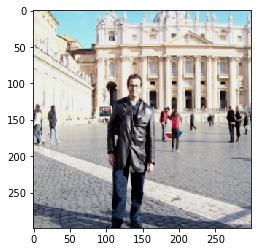

In [231]:
X_example, y_example = next(train_gen)
plt.imshow(X_example[1,:,:,:]/2. + 0.5)

#### The NN model

Let's build the actual model!

In [232]:
K.clear_session()

In [233]:
x_model = Xception(input_shape=list(input_shape) + [3], 
                   weights='imagenet', 
                   include_top=False)

In [234]:
x_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

#### Finetuning

I started with a fully frozen model, then I included various additional layers. I found that freezing layers `1:85` resulted in quite efficient training, but I have trained the layers between 25 and 85 also for a few epochs.

In [235]:
for layer in x_model.layers:
    layer.trainable = True

for layer in x_model.layers[:85]:
    layer.trainable = False   
    
x_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

#### Generalized mean pool

In [236]:
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

#### The top model

In [237]:
X_feat = Input(x_model.output_shape[1:])

lambda_layer = Lambda(generalized_mean_pool_2d)
lambda_layer.trainable_weights.extend([gm_exp])
X = lambda_layer(X_feat)
X = Dropout(0.05)(X)
X = Activation('relu')(X)
X = Dense(n_cat, activation='softmax')(X)

top_model = Model(inputs=X_feat, outputs=X)
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 10, 2048)      0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2048)              1         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
activation_1 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 10,246
Trainable params: 10,246
Non-trainable params: 0
_________________________________________________________________


In [238]:
X_image = Input(list(input_shape) + [3])

X_f = x_model(X_image)
X_f = top_model(X_f)

model = Model(inputs=X_image, outputs=X_f)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
model_1 (Model)              (None, 5)                 10246     
Total params: 20,871,726
Trainable params: 11,640,558
Non-trainable params: 9,231,168
_________________________________________________________________


#### Custom loss function

Individual losses are reweighted on each batch, but each output neuron will still always see a binary cross-entropy loss. In other words, the learning rate is simply higher for the most confident predictions.

In [239]:
def get_custom_loss(rank_weight=1., epsilon=1.e-9):
    def custom_loss(y_t, y_p):
        losses = tf.reduce_sum(-y_t*tf.log(y_p+epsilon) - (1.-y_t)*tf.log(1.-y_p+epsilon), 
                               axis=-1)
        
        pred_idx = tf.argmax(y_p, axis=-1)
        
        mask = tf.one_hot(pred_idx, 
                          depth=y_p.shape[1], 
                          dtype=tf.bool, 
                          on_value=True, 
                          off_value=False)
        pred_cat = tf.boolean_mask(y_p, mask)
        y_t_cat = tf.boolean_mask(y_t, mask)
        
        n_pred = tf.shape(pred_cat)[0]
        _, ranks = tf.nn.top_k(pred_cat, k=n_pred)
        
        ranks = tf.cast(n_pred-ranks, tf.float32)/tf.cast(n_pred, tf.float32)*rank_weight
        rank_losses = ranks*(-y_t_cat*tf.log(pred_cat+epsilon)
                             -(1.-y_t_cat)*tf.log(1.-pred_cat+epsilon))        
        
        return rank_losses + losses
    return custom_loss

#### Additional metric

The GAP is estimated by calculating it on each batch during training.

In [240]:
def batch_GAP(y_t, y_p):
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP

This is just a reweighting to yield larger numbers for the loss..

In [241]:
def binary_crossentropy_n_cat(y_t, y_p):
    return keras.metrics.binary_crossentropy(y_t, y_p) * n_cat

#### Training

I manually decreased the learning rate during training, starting at about 0.001 for training the `top_model` (on a larger `batch_size` of 128 or so).

In [242]:
opt = Adam(lr=0.0001)
loss = get_custom_loss(1.0)
#loss='categorical_crossentropy'
#loss='binary_crossentropy'
model.compile(loss=loss, 
              optimizer=opt, 
              metrics=[binary_crossentropy_n_cat, 'accuracy', batch_GAP])

In [243]:
checkpoint1 = ModelCheckpoint('dd_checkpoint-1.h5', 
                              period=1, 
                              verbose=1, 
                              save_weights_only=True)
checkpoint2 = ModelCheckpoint('dd_checkpoint-2.h5', 
                              period=1, 
                              verbose=1, 
                              save_weights_only=True)
checkpoint3 = ModelCheckpoint('dd_checkpoint-3-best.h5', 
                              period=1, 
                              verbose=1, 
                              monitor='loss', 
                              save_best_only=True, 
                              save_weights_only=True)

In [246]:
K.set_value(model.optimizer.lr, 3e-5) # 0.0000003

#### Training

In [247]:
model.fit_generator(train_gen, 
                    steps_per_epoch=len(train_info) / batch_size / 8, 
                    epochs=20, #Heidi: changed from 50
                    callbacks=[checkpoint1, checkpoint2, checkpoint3])

Epoch 1/20
20/19 [===============================] - 180s 9s/step - loss: 2.7923 - binary_crossentropy_n_cat: 2.4522 - acc: 0.3719 - batch_GAP: 0.1803

Epoch 00001: saving model to dd_checkpoint-1.h5

Epoch 00001: saving model to dd_checkpoint-2.h5

Epoch 00001: loss improved from inf to 2.79229, saving model to dd_checkpoint-3-best.h5
Epoch 2/20
20/19 [===============================] - 177s 9s/step - loss: 2.3497 - binary_crossentropy_n_cat: 2.0017 - acc: 0.5312 - batch_GAP: 0.3413

Epoch 00002: saving model to dd_checkpoint-1.h5

Epoch 00002: saving model to dd_checkpoint-2.h5

Epoch 00002: loss improved from 2.79229 to 2.34969, saving model to dd_checkpoint-3-best.h5
Epoch 3/20
20/19 [===============================] - 192s 10s/step - loss: 2.0115 - binary_crossentropy_n_cat: 1.6816 - acc: 0.6719 - batch_GAP: 0.4839

Epoch 00003: saving model to dd_checkpoint-1.h5

Epoch 00003: saving model to dd_checkpoint-2.h5

Epoch 00003: loss improved from 2.34969 to 2.01149, saving model to d

In [248]:
model.save_weights('dd_1.h5')

#### Some evaluations

In [249]:
K.eval(gm_exp)

3.0066729

In [250]:
print(model.history.history['loss'])

[2.792286455631256, 2.3496851921081543, 2.01149325966835, 1.416637435555458, 1.2100563317537307, 0.9603161513805389, 0.8161785066127777, 0.7882533316473359, 0.6456409797072411, 0.642059751600027, 0.7646938741207123, 0.48798849806189537, 0.547413120418787, 0.5923281326889992, 0.3548925664275885, 0.4891789152398464, 0.39514388553798196, 0.4032143011689186, 0.41602119281888006, 0.34253474697470665]


Text(0, 0.5, 'loss')

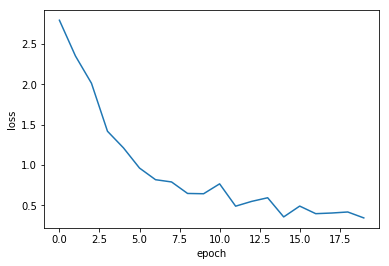

In [251]:
plt.plot(model.history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'batch_GAP')

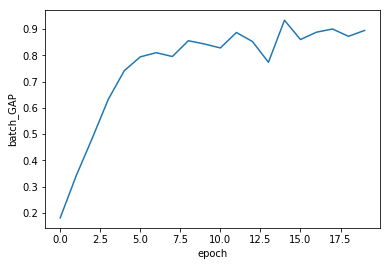

In [252]:
plt.plot(model.history.history['batch_GAP'])
plt.xlabel('epoch')
plt.ylabel('batch_GAP')

Text(0, 0.5, 'acc')

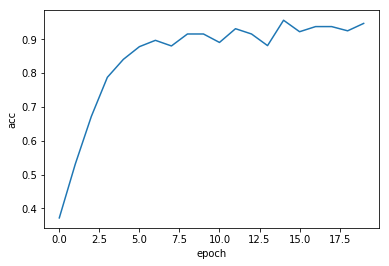

In [253]:
plt.plot(model.history.history['acc'])
plt.xlabel('epoch')
plt.ylabel('acc')

#### Validation and prediciton

In [254]:
def predict(info, load_n_images=1024):
    n = len(info)
    max_p = np.zeros(n)
    pred = np.zeros(n)
    
    for ind in range(0,len(info),load_n_images):
        imgs = load_images(info.iloc[ind:(ind+load_n_images)])
        imgs = preprocess_input(imgs)
        proba = model.predict(imgs, batch_size=batch_size_predict)
        
        pred_i = np.argmax(proba, axis=1)
        max_p[ind:(ind + load_n_images)] = proba[np.arange(len(pred_i)),pred_i]
        pred[ind:(ind + load_n_images)] = label_encoder.inverse_transform(pred_i)
        
        print(ind, '/', len(info), '  -->', pred[ind], max_p[ind])

    print(len(info), '/', len(info), '  -->', pred[-1], max_p[-1])
    
    return pred, max_p

Ok, this is a version with 12 crops, for the competition I found that 22 crops with crop_p=0.05 and crop_p=0.15 worked even better.

In [255]:
def predict_wcr_vote(info, load_n_images=1024, crop_p=0.1, n_crops = 12):
    n = len(info)
    max_p = np.zeros(n)
    pred = np.zeros(n)
    
    for ind in range(0,len(info),load_n_images):
        all_proba = np.zeros((n_crops, min(load_n_images, len(info)-ind), n_cat))
        
        imgs = load_images(info.iloc[ind:(ind+load_n_images)])
        imgs = preprocess_input(imgs)
        
        #full image
        all_proba[0,:,:] = model.predict(imgs, batch_size=batch_size_predict)
        all_proba[1,:,:] = model.predict(np.flip(imgs, axis=2), 
                                         batch_size=batch_size_predict)
        
        crops = ['upper left', 'lower left', 'upper right', 'lower right', 'central']
        jnd_0 = 2
        for jnd,crop in enumerate(crops):
            imgs = load_cropped_images(info.iloc[ind:(ind+load_n_images)], 
                                  crop_p=crop_p, crop=crop)  # optimize later
            imgs = preprocess_input(imgs)
            all_proba[jnd_0+2*jnd,:,:] = model.predict(imgs, 
                                                       batch_size=batch_size_predict)
            all_proba[jnd_0+2*jnd+1,:,:] = model.predict(np.flip(imgs, axis=2), 
                                                         batch_size=batch_size_predict)
        
        cmax_p = np.zeros((n_crops,imgs.shape[0]))
        cpred = np.zeros((n_crops,imgs.shape[0]))
        for jnd in range(all_proba.shape[0]):
            proba = all_proba[jnd,:,:]
            pred_i = np.argmax(proba, axis=1)
            cmax_p[jnd,:] = proba[np.arange(len(pred_i)),pred_i]
            cpred[jnd,:] = label_encoder.inverse_transform(pred_i)
        
        for knd in range(imgs.shape[0]):
            c_res = pd.DataFrame({'max_cat':cpred[:,knd], 'max_p':cmax_p[:,knd]})
            c_res = c_res.groupby('max_cat').aggregate('sum') / n_crops
            pred[ind + knd]=c_res['max_p'].idxmax()
            max_p[ind + knd]=c_res.loc[pred[ind + knd]]['max_p']
                  
        print(ind,'/',len(info), '  -->', pred[ind], max_p[ind])
    print(len(info),'/',len(info), '  -->', pred[-1], max_p[-1])
    
    return pred, max_p

In [256]:
def validate(info, load_n_images=1024, wcr=False, crop_p=0.1):
    if wcr:
        pred, max_p = predict_wcr_vote(info, load_n_images=load_n_images, crop_p=crop_p)
    else:
        pred, max_p = predict(info, load_n_images=load_n_images)
    
    y = info['landmark_id'].values
    binary_acc = accuracy_score(y, pred)

    sort_ind = np.argsort(max_p)[::-1]

    pred = pred[sort_ind]
    y_true = y[sort_ind]

    GAP = np.sum(np.cumsum(pred == y_true) * (pred == y_true) / np.arange(1, len(y_true) + 1)) / np.sum(y_true >= 0.)

    print("accuracy:", binary_acc, "\n ")
    print("*** GAP:", GAP, "***")
    
    return binary_acc, GAP


Validate only on landmark images

In [257]:
dev_binary_acc, dev_GAP = validate(dev_info, 50)

0 / 2469   --> 9779.0 0.9585930109024048
50 / 2469   --> 2061.0 0.6989235877990723
100 / 2469   --> 9779.0 0.9906184077262878
150 / 2469   --> 9633.0 0.9990823268890381
200 / 2469   --> 9633.0 0.9993185997009277


KeyboardInterrupt: 

Validate on landmark and non-landmark images

In [123]:
dev_binary_acc, dev_GAP = validate(pd.concat([dev_info, nlm_dev_df]).sample(frac=1), 1024)

NameError: name 'nlm_dev_df' is not defined

In [ ]:
dev_binary_acc_wcr, dev_GAP_wcr = validate(dev_info, 1024, wcr=True, crop_p=0.1)

Some checks before actual prediction

In [ ]:
print(len(test_info))

In [ ]:
_, _ = predict_wcr_vote(test_info[:10], 512, crop_p=0.1)

In [ ]:
#test_pred, test_max_p = predict(test_info, 1024)

And predict!

In [ ]:
test_pred, test_max_p = predict_wcr_vote(test_info, 512, crop_p=0.1)

In [ ]:
predictions = pd.DataFrame(columns=['landmarks'], index=test_info.index)
predictions['landmarks'] = [str(int(tp))+' '+ '%.16g' % pp 
                            for tp,pp in zip(test_pred, test_max_p)]
predictions.head()

In [ ]:
test_info_full = pd.read_csv('test.csv', index_col=0)
test_info_full.head()

Fill the missing values with the most common landmark

In [ ]:
missing = test_info_full[test_info_full.index.isin(test_info.index)!=True]
missing_predictions = pd.DataFrame(index=missing.index)
missing_predictions['landmarks'] = '9633 0.0'
missing_predictions.head()

In [ ]:
completed_predictions = pd.concat([predictions, missing_predictions])
print(len(completed_predictions))

In [ ]:
sorted_predictions = pd.DataFrame(index=test_info_full.index)
sorted_predictions['landmarks'] = completed_predictions['landmarks']
sorted_predictions.tail()

In [ ]:
sorted_predictions.to_csv('prediction_c12.csv')